In [1]:
sc

In [2]:
import numpy as np
import optimize_camera as optimize
import project_lidar as project
import matplotlib.pyplot as pl
%matplotlib inline

In [3]:
def colin(params, xyz_a):

	# Unwrap params
	kappa, phi, omega, xs, ys, zs, f = params

	omega = float(omega)
	phi = float(phi) + 0.5*np.pi
	kappa = float(kappa)
	xs = float(xs)
	ys = float(ys)
	zs = float(zs)
	f = float(f)

	# -- utils
	co = np.cos(omega)
	so = np.sin(omega)
	cp = np.cos(phi)
	sp = np.sin(phi)
	ck = np.cos(kappa)
	sk = np.sin(kappa)

	a1 =  cp*ck+sp*so*sk
	b1 =  cp*sk+sp*so*ck
	c1 =  sp*co
	a2 = -co*sk
	b2 =  co*ck
	c2 =  so
	a3 =  sp*ck+cp*so*sk
	b3 =  sp*sk-cp*so*ck
	c3 =  cp*co

	ynum  = a1*(xyz_a[:,0]-xs)+b1*(xyz_a[:,1]-ys)+c1*(xyz_a[:,2]-zs)
	xnum  = a2*(xyz_a[:,0]-xs)+b2*(xyz_a[:,1]-ys)+c2*(xyz_a[:,2]-zs)
	denom = a3*(xyz_a[:,0]-xs)+b3*(xyz_a[:,1]-ys)+c3*(xyz_a[:,2]-zs)

	xx = -f*xnum/denom
	yy = f*ynum/denom

	return np.vstack([xx,yy]).T

In [4]:
def project(content):
    import numpy as np
    import colin
    from project_lidar import in_picture
    from project_lidar import distance

    # Finds the desired projection
    
#     if globparams == None:
#         params = return_params(globname)
#     else:
#         params = globparams

    params = [4.48603184e+00, -6.39366995e-02, 1.01077828e-35, 9.88508193e+05,
          2.14483372e+05, 7.97190735e+02, 2.85647278e+03]

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])

    # Rearrange
#     print "working on: ", filename
#     dat = np.load(filename).copy()
    dat = np.frombuffer(bytes(content))
    dat = dat[10:].reshape(-1, 3)
    

    # Multiply by -1 because it apears as inverse; use orient?
    pixel_xy = 1.0*colin.colin(params, dat) 

    # un-center pixel (x,y)
    x = image_dims[0]/2 - pixel_xy[:,0].astype(int)
    y = image_dims[1]/2 + pixel_xy[:,1].astype(int)

    is_in_picture = in_picture(x,y,image_dims)

    index = np.arange(is_in_picture.size)[is_in_picture>0]

    print "npix = ", index.size

    distgrid = np.ones(image_dims_reversed)*(100000.0)
    xgrid =  -1.*np.ones(image_dims_reversed)
    ygrid = -1.*np.ones(image_dims_reversed)

    if index.size==0:
        #print "no points, returning..."
        return [distgrid, xgrid, ygrid]
        #yield [distgrid, xgrid, ygrid]

    n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
    x   = x[index]
    y   = y[index]
    dat = dat[index]

    # Add each point to the arrays, given it is visibile (vis[i] == 1)
    # And it is closer to the camera than the current value stored in 
    # the corresponding pixel of the distance array

    nx = distgrid.shape[1]-1
    ny = distgrid.shape[0]-1

    for ii in range(index.size):
        if n[ii]<distgrid[ny-y[ii],nx-x[ii]] and n[ii]>500:
            distgrid[ny-y[ii],nx-x[ii]] = n[ii]
            xgrid[ny-y[ii],nx-x[ii]] = dat[ii,0]
            ygrid[ny-y[ii],nx-x[ii]] = dat[ii,1]

    #print "Done with: ",filename
    return [distgrid, xgrid, ygrid]
    print xgrid[0,0]
    #yield [distgrid, xgrid, ygrid]


In [11]:
lidar_fiducials = np.array([
                            [988224.09, 211951.573,1494.756662], #Empire state building
                            [980598.406, 199043.071,1750.127224], #WTC
                            [987656.616, 211766.233,493.89], # 1250 Broadway
                            [983564.98, 199358.775,591.406796], # Marshall courthouse
                            [987342.468, 212511.054,380.69], #  112 West 34th St
                            [988596.086, 211789.785,255.31], # 347 5th Ave
                            [988287.232, 213228.734,488.716947]])

In [5]:
def project_one(filename):
    import numpy as np
    import colin
    from project_lidar import in_picture
    from project_lidar import distance

    # Finds the desired projection
    
#     if globparams == None:
#         params = return_params(globname)
#     else:
#         params = globparams

    params = [4.48603184e+00, -6.39366995e-02, 1.01077828e-35, 9.88508193e+05,
          2.14483372e+05, 7.97190735e+02, 2.85647278e+03]

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])

    #Rearrange
    print "working on: ", filename
    dat = np.load(filename).copy()
    #dat = np.fromstring(content)

    # Multiply by -1 because it apears as inverse; use orient?
    pixel_xy = 1.0*colin.colin(params, dat) 

    # un-center pixel (x,y)
    x = image_dims[0]/2 - pixel_xy[:,0].astype(int)
    y = image_dims[1]/2 + pixel_xy[:,1].astype(int)

    is_in_picture = in_picture(x,y,image_dims)

    index = np.arange(is_in_picture.size)[is_in_picture>0]

    print "npix = ", index.size

    distgrid = np.ones(image_dims_reversed)*(100000.0)
    xgrid =  -1.*np.ones(image_dims_reversed)
    ygrid = -1.*np.ones(image_dims_reversed)

    if index.size==0:
        print "no points, returning..."
        return [distgrid, xgrid, ygrid]
        #yield [distgrid, xgrid, ygrid]

    n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
    x   = x[index]
    y   = y[index]
    dat = dat[index]

    # Add each point to the arrays, given it is visibile (vis[i] == 1)
    # And it is closer to the camera than the current value stored in 
    # the corresponding pixel of the distance array

    nx = distgrid.shape[1]-1
    ny = distgrid.shape[0]-1

    for ii in range(index.size):
        if n[ii]<distgrid[ny-y[ii],nx-x[ii]] and n[ii]>500:
            distgrid[ny-y[ii],nx-x[ii]] = n[ii]
            xgrid[ny-y[ii],nx-x[ii]] = dat[ii,0]
            ygrid[ny-y[ii],nx-x[ii]] = dat[ii,1]

    print "Done with: ",filename
    return [distgrid, xgrid, ygrid]


In [6]:
# x-978979.241501_y-208815.073690.npy
distgrid, xgrid, ygrid = project_one('data_npy/x-978979.241501_y-198575.073690.npy')

working on:  data_npy/x-978979.241501_y-198575.073690.npy
npix =  3283567
Done with:  data_npy/x-978979.241501_y-198575.073690.npy


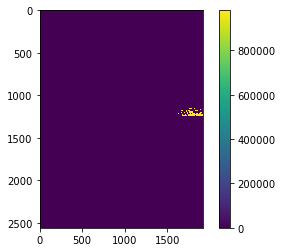

In [7]:
#pl.figure(figsize=(12, 15))
pl.imshow(xgrid)
pl.colorbar()

In [8]:
def merge(final, new):
    
    out = [0, 0, 0]
    replace = np.greater(final[0], new[0])
    out[0] = final[0]*np.logical_not(replace) + new[0]*replace
    out[1] = final[1]*np.logical_not(replace) + new[1]*replace
    out[2] = final[2]*np.logical_not(replace) + new[2]*replace
    
    return out

In [9]:
def read_array2(rdd):
    array=np.fromstring(rdd) 
    return array

In [20]:
def proj_npy(rdd):
    import colin
    from project_lidar import in_picture
    from project_lidar import distance
    
    array=np.frombuffer(bytes(rdd[1]))
    dat = array[10:].reshape(-1, 3)
    
    params = [4.48723386e+00, 5.75616144e-02, 1.14226011e-02, 9.88501080e+05,
              2.14474001e+05, 7.93662680e+02, 2.84534724e+03]

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])
    
    # Multiply by -1 because it apears as inverse; use orient?
    pixel_xy = 1.0*colin.colin(params, dat)
    
    # un-center pixel (x,y)
    x = image_dims[0]/2 - pixel_xy[:,0].astype(int)
    y = image_dims[1]/2 + pixel_xy[:,1].astype(int)
    
    is_in_picture = in_picture(x,y,image_dims)
    
    index = np.arange(is_in_picture.size)[is_in_picture>0]
    
    distgrid = np.ones(image_dims_reversed)*(100000.0)
    xgrid =  -1.*np.ones(image_dims_reversed)
    ygrid = -1.*np.ones(image_dims_reversed)
    
    if index.size==0:
        return [distgrid, xgrid, ygrid]

    n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
    x   = x[index]
    y   = y[index]
    dat = dat[index]

    # Add each point to the arrays, given it is visibile (vis[i] == 1)
    # And it is closer to the camera than the current value stored in 
    # the corresponding pixel of the distance array

    nx = distgrid.shape[1]-1
    ny = distgrid.shape[0]-1

    for ii in range(index.size):
        if n[ii]<distgrid[ny-y[ii],nx-x[ii]] and n[ii]>500:
            distgrid[ny-y[ii],nx-x[ii]] = n[ii]
            xgrid[ny-y[ii],nx-x[ii]] = dat[ii,0]
            ygrid[ny-y[ii],nx-x[ii]] = dat[ii,1]

    
    return [distgrid, xgrid, ygrid]

In [38]:
def reducerTest(final, new):

    out = [0, 0, 0]
    replace = np.greater(final[0], new[0])
    out[0] = final[0]*np.logical_not(replace) + new[0]*replace
    out[1] = final[1]*np.logical_not(replace) + new[1]*replace
    out[2] = final[2]*np.logical_not(replace) + new[2]*replace
    
    
    return out

In [ ]:
def reduce_finalGrid(v1, v2):
    final_grids = [np.ones(image_dims_reversed)*(10**8), \
                    -1*np.ones(image_dims_reversed), \
                    -1*np.ones(image_dims_reversed)]
    
    out = [0, 0, 0]
    replace = np.greater(final[0], new[0])
    out[0] = final[0]*np.logical_not(replace) + new[0]*replace
    out[1] = final[1]*np.logical_not(replace) + new[1]*replace
    out[2] = final[2]*np.logical_not(replace) + new[2]*replace
return out
    

In [46]:
rdd = sc.binaryFiles('data_npy_test/*')
a = rdd.map(proj_npy).reduce(reducerTest)

In [37]:
a

[array([[ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        ..., 
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.]]),
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ..., 
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]),
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ..., 
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [

In [31]:
len(np.where(a.collect()[0][0] < 100000)[0])

8255

In [33]:
len(np.where(a[0]<100000)[0])

19811

In [44]:
a[0]

array([[ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
       [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
       [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
       ..., 
       [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
       [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
       [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.]])

In [40]:
from PIL import Image


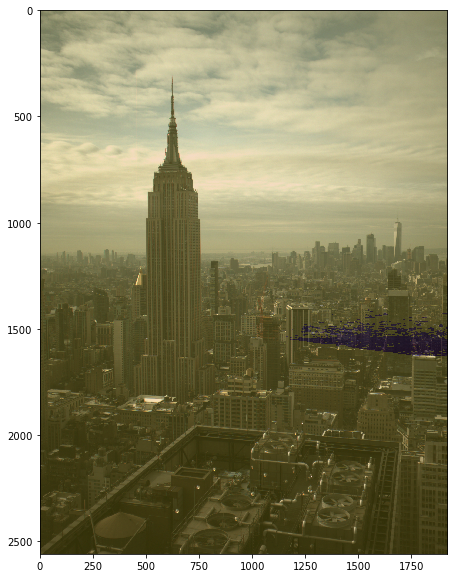

In [47]:
pl.figure(figsize=(10,10))

im = Image.open('./bof_left.png')

pl.imshow(im)
pl.imshow(a[0], alpha=.2)



